In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
import torch.utils as utils
from torchvision import datasets, transforms

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1))])

dataset_train = datasets.MNIST(
    '~/mnist', 
    train=True, 
    download=True, 
    transform=transform)
dataset_valid = datasets.MNIST(
    '~/mnist', 
    train=False, 
    download=True, 
    transform=transform)

batch_size = 1000

dataloader_train = utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)
dataloader_valid = utils.data.DataLoader(dataset_valid,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /home/nske/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /home/nske/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /home/nske/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /home/nske/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /home/nske/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/nske/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /home/nske/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/nske/mnist/MNIST/raw



/home/nske/miniconda3/envs/jp/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
class VAE(nn.Module):
    def __init__(self, x_dim, z_dim):
      super(VAE, self).__init__()
      self.x_dim = x_dim
      self.z_dim = z_dim
      self.fc1 = nn.Linear(x_dim, 20)
      self.bn1 = nn.BatchNorm1d(20)
      self.fc2_mean = nn.Linear(20, z_dim)
      self.fc2_var = nn.Linear(20, z_dim)

      self.fc3 = nn.Linear(z_dim, 20)
      self.drop1 = nn.Dropout(p=0.2)
      self.fc4 = nn.Linear(20, x_dim)

    def encoder(self, x):
      x = x.view(-1, self.x_dim)
      x = F.relu(self.fc1(x))
      x = self.bn1(x)
      mean = self.fc2_mean(x)
      log_var = self.fc2_var(x)
      return mean, log_var

    def sample_z(self, mean, log_var, device):
      epsilon = torch.randn(mean.shape, device=device)
      return mean + epsilon * torch.exp(0.5*log_var)

    def decoder(self, z):
      y = F.relu(self.fc3(z))
      y = self.drop1(y)
      y = torch.sigmoid(self.fc4(y))
      return y

    def forward(self, x, device):
      x = x.view(-1, self.x_dim)
      mean, log_var = self.encoder(x)
      delta = 1e-8
      KL = 0.5 * torch.sum(1 + log_var - mean**2 - torch.exp(log_var))
      z = self.sample_z(mean, log_var, device)
      y = self.decoder(z)
      # 本来はmeanだがKLとのスケールを合わせるためにsumで対応
      reconstruction = torch.sum(x * torch.log(y + delta) + (1 - x) * torch.log(1 - y + delta))
      lower_bound = [KL, reconstruction]
      return -sum(lower_bound), z, y

In [8]:
model = VAE(x_dim=28*28, z_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

num_epochs = 20
loss_list = []
for i in range(num_epochs):
  losses = []
  for x, t in dataloader_train:
      x = x.to(device)
      loss, z, y = model(x, device)
      model.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.cpu().detach().numpy())
  loss_list.append(np.average(losses))
  print("EPOCH: {} loss: {}".format(i, np.average(losses)))

EPOCH: 0 loss: 494603.6875
EPOCH: 1 loss: 305838.59375
EPOCH: 2 loss: 234424.140625
EPOCH: 3 loss: 214462.78125
EPOCH: 4 loss: 203218.265625
EPOCH: 5 loss: 196463.75
EPOCH: 6 loss: 192243.15625
EPOCH: 7 loss: 188345.34375
EPOCH: 8 loss: 184437.0
EPOCH: 9 loss: 180969.046875
EPOCH: 10 loss: 178109.015625
EPOCH: 11 loss: 175759.234375
EPOCH: 12 loss: 173627.1875
EPOCH: 13 loss: 171902.671875
EPOCH: 14 loss: 170514.78125
EPOCH: 15 loss: 169238.53125
EPOCH: 16 loss: 168032.84375
EPOCH: 17 loss: 166984.484375
EPOCH: 18 loss: 166270.96875
EPOCH: 19 loss: 165279.4375


TypeError: forward() missing 1 required positional argument: 'device'

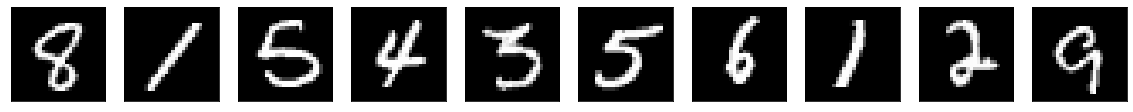

In [9]:
fig = plt.figure(figsize=(20, 6))

model.eval()
zs = []
for x, t in dataloader_valid:
    for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
      ax.imshow(im, 'gray')

    x = x.to(device)
    y, z = model(x)
    zs.append(z)
    y = y.view(-1, 28, 28)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    
    z1to0 = torch.cat([z[1, :] * (i * 0.1) + z[0, :] * ((10 - i) * 0.1) for i in range(10)]).reshape(10, 10)
    y2 = model._decoder(z1to0).view(-1, 28, 28)
    for i, im in enumerate(y2.cpu().detach().numpy()[:20]):
      ax = fig.add_subplot(3, 10, i+21, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    break

In [11]:
from sklearn.manifold import TSNE
from random import random

colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
def visualize_zs(zs, labels):
  plt.figure(figsize=(10,10))
  points = TSNE(n_components=2, random_state=0).fit_transform(zs)
  for p, l in zip(points, labels):
    plt.scatter(p[0], p[1], marker="${}$".format(l), c=colors[l])
  plt.show()

model.eval()
zs = []
for x, t in dataloader_valid:
    x = x.to(device)
    t = t.to(device)
    # generate from x
    y, z = model(x)
    z = z.cpu()
    t = t.cpu()
    visualize_zs(z.detach().numpy(), t.cpu().detach().numpy())
    break